In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole

import nglview as nv

from druglab.pharmn.generator import PharmGenerator
from druglab.pharmn.parser import PharmDefaultParser
from druglab.pharmn.adjusters import InternalStericAdjuster


idx = 0
smiles = [
    "C2NCc1c2c(Oc3cocc3)cc(C(=O)CO)c1",
    "C=N-Cc1[nH]ncc1CN",
    "C2[NH2+]Cc1c2c(Sc3cscc3)cc(C(=O)CO)c1C(=O)[O-]"
]
mols = [Chem.MolFromSmiles(s) for s in smiles]
mols = [Chem.AddHs(m) for m in mols]
[rdDistGeom.EmbedMolecule(m) for m in mols]
[rdForceFieldHelpers.MMFFOptimizeMolecule(m) for m in mols]

parser = PharmDefaultParser()
pgen = PharmGenerator()
definitions = parser.parse("definitions.pharm")
pgen.load_definitions(definitions)

ps = [pgen.generate(mol) for mol in mols]
[InternalStericAdjuster().adjust(p, m.GetConformer()) for p, m in zip(ps, mols)]

[None, None, None]

In [2]:
from druglab.pharmn.profiler import PharmAFProfiler

pro1 = PharmAFProfiler(definitions.ftypes).profile(ps[0])
pro2 = PharmAFProfiler(definitions.ftypes).profile(ps[2])

pro1.match(pro2)

(array([9.02533464e-01, 7.97466335e-01, 7.55730797e-01, 7.01525149e-01,
        6.67173963e-01, 5.97083317e-01, 5.96106576e-01, 5.83331908e-01,
        5.61929162e-01, 4.09336996e-01, 3.06516434e-01, 2.75815905e-01,
        2.73793346e-01, 1.98843539e-01, 1.67648272e-01, 1.10405115e-01,
        3.33222259e-04, 3.33222259e-04, 3.33222259e-04, 3.33222259e-04,
        3.33222259e-04]),
 [(2, 2),
  (1, 10),
  (4, 4),
  (11, 15),
  (5, 5),
  (18, 26),
  (20, 30),
  (12, 16),
  (10, 18),
  (0, 9),
  (9, 17),
  (19, 23),
  (13, 22),
  (16, 27),
  (15, 21),
  (3, 3),
  (8, 7),
  (7, 6),
  (6, 8),
  (14, 12),
  (17, 11)])

In [10]:
pro1.orig_atids[1], pro2.orig_atids[10]

(((21,), (6,)), ((25,), (20,)))

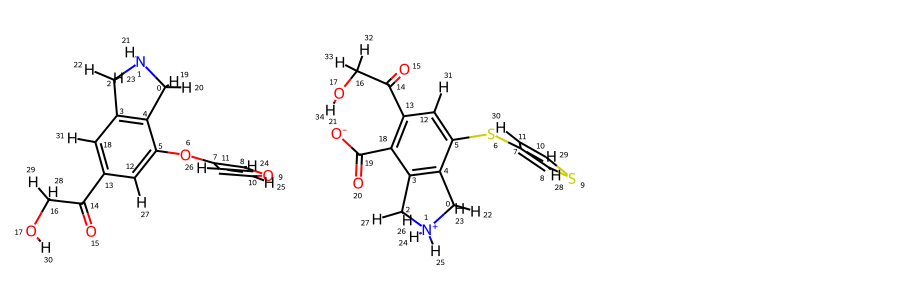

In [4]:
IPythonConsole.drawOptions.addAtomIndices = True

IPythonConsole.ShowMols([mols[0], mols[2]], subImgSize=(300, 300))

In [7]:
view = nv.NGLWidget()
view.add_component(mols[0])
ps[0].draw(view)
view

NGLWidget()

In [8]:
view = nv.NGLWidget()
view.add_component(mols[2])
ps[2].draw(view)
view

NGLWidget()

In [3]:
from druglab.pharmn.profiler import PharmFFFProfiler

PharmFFFProfiler(definitions.ftypes).profile(ps[0]).match(
    PharmFFFProfiler(definitions.ftypes).profile(ps[2])
)

(array([6.36319189e-01, 3.33222259e-04, 3.33222259e-04, 3.33222259e-04,
        3.33222259e-04, 3.33222259e-04, 3.33222259e-04, 3.33222259e-04,
        3.33222259e-04, 1.27098568e-01, 3.07720533e-01, 2.29009936e-01,
        1.13879961e-01, 1.73457182e-01, 3.80167704e-01, 1.79330363e-01,
        1.20426805e-01, 9.82728326e-02, 3.33222259e-04, 3.33222259e-04,
        2.54302459e-01]),
 [(0, 4),
  (1, 1),
  (2, 2),
  (3, 5),
  (4, 9),
  (5, 0),
  (6, 7),
  (7, 6),
  (8, 8),
  (9, 22),
  (10, 25),
  (11, 16),
  (12, 32),
  (13, 17),
  (14, 31),
  (15, 21),
  (16, 35),
  (17, 18),
  (18, 3),
  (19, 10),
  (20, 41)])

In [4]:
ps[2].vec

array([[-0.49063945, -0.26957097,  0.82861597],
       [ 0.34457804, -0.82032998, -0.45642601],
       [-0.82548851,  0.54721114, -0.1383065 ],
       [-0.14793626,  0.84667425, -0.51113362],
       [ 0.8752691 , -0.1285363 , -0.46624289],
       [-0.67356427, -0.47070372, -0.56986768],
       [ 0.51109876, -0.02591253, -0.85913131],
       [-0.51109876,  0.02591253,  0.85913131],
       [ 0.53633443,  0.83826845,  0.09824146],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan]])

In [3]:
PharmFFFProfiler(definitions.ftypes).profile(ps[0])

PharmDistProfile(21)

In [6]:
PharmFFFProfiler(definitions.ftypes)._get_dists(ps[0], 1, 2, 3, 4, 5, 0)

array([0.        , 7.30847372, 9.83860144, 8.09903398, 8.34126769,
       7.30847372, 9.83860144, 8.09903398, 8.34126769, 3.5254466 ,
       4.42023135, 4.72043264, 6.8519534 , 7.39802864, 1.02052021])

In [ ]:
from __future__ import annotations
from typing import List, Tuple, Dict, OrderedDict
from dataclasses import dataclass, field
from itertools import combinations

import numpy as np
from scipy.optimize import linear_sum_assignment

from druglab.pharmn.ftypes import PharmFeatureType, PharmArrowType
from druglab.pharmn.pharmacophore import Pharmacophore


@dataclass(repr=False)
class PharmFFFProfile:
    combtypeids: np.ndarray
    orig_atids: List[Tuple[Tuple[int]]]
    d12: np.ndarray
    d13: np.ndarray
    d23: np.ndarray

    def __repr__(self):
        return (f"PharmFFFProfile({self.combtypeids.shape[0]})")
    
    def match(self, other: PharmFFFProfile):
        diff12 = (self.d12[:, None] - other.d12[None, :]) ** 2
        diff13 = (self.d13[:, None] - other.d13[None, :]) ** 2
        diff23 = (self.d23[:, None] - other.d23[None, :]) ** 2

        mask = self.combtypeids[:, None] == other.combtypeids[None, :]

        diff = ((diff12 + diff13 + diff23) / 3) ** 0.5
        diff[~mask] = 100
        sidx, oidx = linear_sum_assignment(diff)

        score = 1 / (1 + 3*diff)
        score[~mask] = 0.0
        return score[sidx, oidx], sidx, oidx  

class PharmFFFProfiler:

    def __init__(self, ftypes: OrderedDict[str, PharmFeatureType]):
        self.ftypes: List[PharmFeatureType] = list(ftypes.values())
        self.combids: List[Tuple[int, int, int]] = \
            self.combinations(self.ftypes)

    def __repr__(self):
        return (f"PharmFFFProfiler(nftypes={len(self.ftypes)}, "
                f"ncombids={len(self.combids)})")

    @staticmethod
    def combinations(ftypes: List[PharmFeatureType]) \
        -> Tuple[int, int, int]:
        
        return [(i,j,k) 
                for i in range(len(ftypes))
                for j in range(i, len(ftypes))
                for k in range(j, len(ftypes))]
    
    def profile(self, pharmacophore: Pharmacophore) -> PharmFFFProfile:

        mindist = 0.0

        combtypeids = []
        d12s, d13s, d23s = [], [], []
        orig_atids = []

        for i, j, k in combinations(range(pharmacophore.n_feats), r=3):
            fti = pharmacophore.get_ftype(i)
            ftj = pharmacophore.get_ftype(j)
            ftk = pharmacophore.get_ftype(k)

            ftidi = self.ftypes.index(fti)
            ftidj = self.ftypes.index(ftj)
            ftidk = self.ftypes.index(ftk)
            
            try:
                combtypeid = self.combids.index((ftidi, ftidj, ftidk))
            except:
                continue
            
            d12 = pharmacophore.get_distance(i, j)
            d13 = pharmacophore.get_distance(i, k)
            d23 = pharmacophore.get_distance(j, k)

            if d12 == 0 or d13 == 0 or d23 == 0:
                continue
            
            combtypeids.append(combtypeid)
            orig_atids.append(
                (
                    pharmacophore.orig_atids[i],
                    pharmacophore.orig_atids[j],
                    pharmacophore.orig_atids[k]
                )
            )
            d12s.append(d12)
            d13s.append(d13)
            d23s.append(d23)

        keep_origatids = set()
        keep_idx = []
        for i, oatids in enumerate(orig_atids):
            if oatids not in keep_origatids:
                keep_origatids.add(oatids)
                keep_idx.append(i)
        
        return PharmFFFProfile(
            combtypeids=np.array(combtypeids)[keep_idx],
            orig_atids=[orig_atids[i] for i in keep_idx],
            d12=np.array(d12s)[keep_idx],
            d13=np.array(d13s)[keep_idx],
            d23=np.array(d23s)[keep_idx]
        )
            

profiler = PharmFFFProfiler(definitions.ftypes)
pros = [profiler.profile(p) for p in ps]
pros

[PharmFFFProfile(21), PharmFFFProfile(5), PharmFFFProfile(66)]

In [15]:
pros[0].combtypeids, pros[1].combtypeids

(array([19,  0,  0,  2,  2,  0,  2,  2,  2,  2,  9,  0,  2,  2,  2,  2,  9,
         2,  2,  9,  9]),
 array([16,  0,  2,  2,  2]))

In [16]:
profiler.combids[15]

(1, 1, 1)

In [17]:
pros[0].orig_atids[:5], pros[1].orig_atids[:5]

([((21,), (3, 4, 5, 12, 13, 18), (7, 8, 9, 10, 11)),
  ((17,), (6,), (9,)),
  ((17,), (6,), (1,)),
  ((17,), (6,), (3, 4, 5, 12, 13, 18)),
  ((17,), (6,), (7, 8, 9, 10, 11))],
 [((14,), (19,), (3, 4, 5, 6, 7)),
  ((1,), (5,), (9,)),
  ((1,), (5,), (3, 4, 5, 6, 7)),
  ((1,), (9,), (3, 4, 5, 6, 7)),
  ((5,), (9,), (3, 4, 5, 6, 7))])

In [38]:
molid1 = 0
molid2 = 2
scores, id1, id2 = pros[molid1].match(pros[molid2])
scores.sum() / (1 + min(ps[molid1].n_feats, ps[molid2].n_feats))

0.23515672996491385

In [24]:
for score, i, j in zip(scores, id1, id2):
    print(score, pros[molid1].orig_atids[i], "===", pros[molid2].orig_atids[j], "|", pros[molid1].combtypeids[i], pros[molid2].combtypeids[j])

0.5750132689163941 ((21,), (3, 4, 5, 12, 13, 18), (7, 8, 9, 10, 11)) === ((25,), (3, 4, 5, 12, 13, 18), (7, 8, 9, 10, 11)) | 19 19
0.0 ((17,), (6,), (9,)) === ((24,), (25,), (3, 4, 5, 12, 13, 18)) | 0 16
0.0 ((17,), (6,), (1,)) === ((24,), (25,), (7, 8, 9, 10, 11)) | 0 16
0.18313302048934743 ((17,), (6,), (3, 4, 5, 12, 13, 18)) === ((17,), (20,), (3, 4, 5, 12, 13, 18)) | 2 2
0.0 ((17,), (6,), (7, 8, 9, 10, 11)) === ((24,), (34,), (21, 19)) | 2 18
0.0 ((17,), (9,), (1,)) === ((24,), (25,), (34,)) | 0 15
0.0 ((17,), (9,), (3, 4, 5, 12, 13, 18)) === ((24,), (25,), (21, 19)) | 2 18
0.0 ((17,), (9,), (7, 8, 9, 10, 11)) === ((24,), (34,), (7, 8, 9, 10, 11)) | 2 16
0.0 ((17,), (1,), (3, 4, 5, 12, 13, 18)) === ((24,), (34,), (1, 0, 2, 24, 25)) | 2 17
0.1046231802269673 ((17,), (1,), (7, 8, 9, 10, 11)) === ((17,), (20,), (7, 8, 9, 10, 11)) | 2 2
0.5930794432173817 ((17,), (3, 4, 5, 12, 13, 18), (7, 8, 9, 10, 11)) === ((17,), (3, 4, 5, 12, 13, 18), (7, 8, 9, 10, 11)) | 9 9
0.15358676919414474 ((

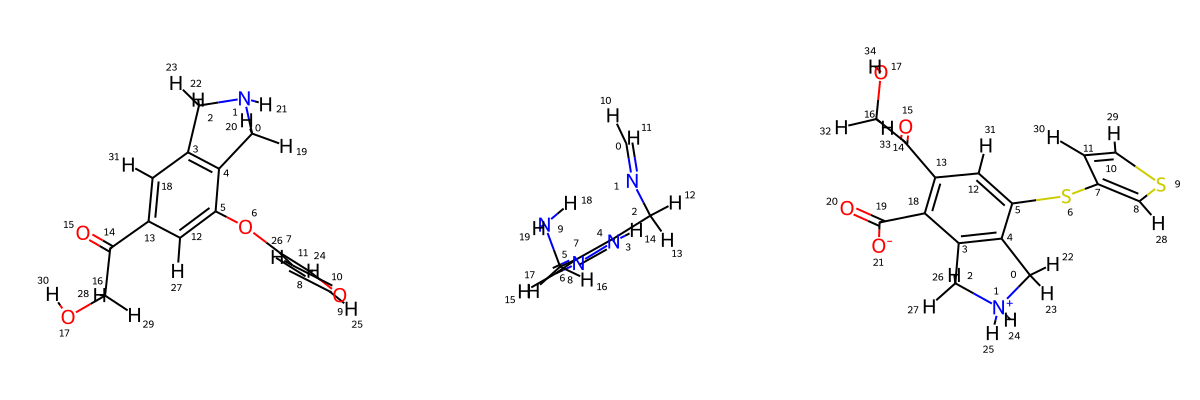

In [13]:
IPythonConsole.drawOptions.addAtomIndices = True

IPythonConsole.ShowMols(mols, subImgSize=(400, 400), molsPerRow=3)

In [193]:
view = nv.NGLWidget()
view.add_component(mols[molid1])
ps[molid1].draw(view)
view

NGLWidget()

In [194]:
view = nv.NGLWidget()
view.add_component(mols[molid2])
ps[molid2].draw(view)
view

NGLWidget()

In [3]:
idx1 = 0
idx2 = 2

ps = [pgen.generate(mol) for mol in mols]
[InternalStericAdjuster().adjust(p, m.GetConformer()) for p, m in zip(ps, mols)]
profiles = [definitions.profiler.profile(p) for p in ps]

matches = profiles[idx1].distances.match(profiles[idx2].distances)
score = matches.score()
score = score / (1+min(ps[idx1].n_feats, ps[idx2].n_feats))
score

1.1313014056275745

In [4]:
profiles[idx1].distances.pair_members

[(PharmArrowType(name='HBondAcc'), PharmArrowType(name='HBondAcc')),
 (PharmArrowType(name='HBondAcc'), PharmArrowType(name='HBondHyd')),
 (PharmArrowType(name='HBondAcc'), PharmArrowType(name='Aromatic')),
 (PharmArrowType(name='HBondHyd'), PharmArrowType(name='HBondHyd')),
 (PharmArrowType(name='HBondHyd'), PharmArrowType(name='Aromatic')),
 (PharmArrowType(name='Aromatic'), PharmArrowType(name='Aromatic'))]

In [5]:
matches[0]

[MDist(6|9(3.53), 17|15(3.64)),
 MDist(6|1(4.42), 17|20(4.51)),
 MDist(9|1(6.85), 15|20(4.91))]

In [6]:
view = nv.NGLWidget()
view.add_component(mols[idx1])
ps[idx1].draw(view)
view

NGLWidget()

In [7]:
view = nv.NGLWidget()
view.add_component(mols[idx2])
ps[idx2].draw(view)
view

NGLWidget()

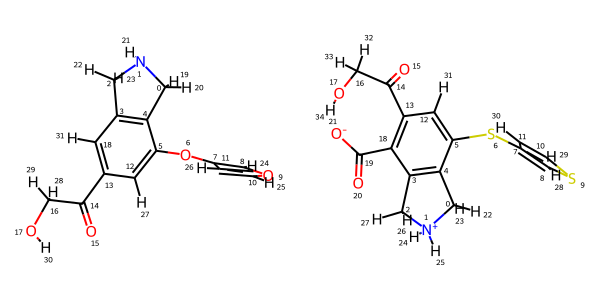

In [8]:
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = (300, 300)

IPythonConsole.ShowMols([mols[idx1], mols[idx2]], subImgSize=(300, 300), molsPerRow=2)

In [49]:
s = r"""C[N+]1(CC2CCCCC2)CCCCC1 1775976787
O=[N+]([O-])/C=C/c1cccc2ccccc12 96773
Oc1cccc2cc3ccccc3nc12 4517670
C[C@@H](C1CCCCC1)[N+]1(C)CCCC1 1775976289
Cc1cc2cccnc2c2ncccc12 120047
C[N+](C)(C)c1cccc2ccccc12 3200691
CC1(C)C=Cc2ccccc2[N+]1(C)C 3123704
Cc1ccc2ccccc2c1[N+](=O)[O-] 160684
CCC[N+]1(CCC)CCCCCC1 114400658
CC[C@@H](C)c1ccccc1[N+](=O)[O-] 5651111
CC[C@H](C)c1ccc([N+](=O)[O-])cc1 5925506
CCCSc1ccc([N+](=O)[O-])cc1 1764627
Cc1ccc(C(C)C)cc1[N+](=O)[O-] 1700212
C[N+]1(C2CCCCCCC2)CCCC1 147018101
CC(C)Sc1ccccc1[N+](=O)[O-] 139769852
CC(=O)/C=C/[C@@H]1[C@H](C)C=C(C)C[C@H]1C 253389220
SCCCCCOc1ccccc1 3876699
C=C(C)CC[C@@H]1[C@@H](C)CC[C@H](O)[C@H]1C 43762663
C=C1C=C[C@@H](C(C)C)CC1 1531621
C=C[C@@H]1C[C@]2(C)CCC(C)(C)[C@@H]2C1=O 71785982
Cc1oc(-c2ccccc2)cc1C#N 3164876
N#Cc1ccccc1Oc1ccccc1 12370408
CCCCCCCCCC(=O)N(C)C 1718165
CCCCCCC[C@H](C)C(=O)O 2530734
C=C(C)COc1ccccc1Cl 70233553
C[C@H]1CCCC2=C1C(=O)CC2(C)C 39236800
C=CC[C@H](N)c1cccc2ccccc12 44138975
C=C[C@H]1C[C@]2(C)CCC(C)(C)[C@@H]2C1=O 71785983
C=C1CCC[C@]2(C1)C[C@H](C)CCO2 34449492
C=C1CCCC[C@@H]2C[C@@H]2C1 71785491
C/C=C/C(=O)C1=C(C)C=CCC1(C)C 100070359
CCCCC/C=C\CCC=O 4538403
C1=CCC[C@@H]2O[C@H]2CCC=CCC1 254822835
CC[C@H](C#N)C1=CCCCCC1 4787171
c1ccc([C@H]2O[C@@H]2c2ccccc2)cc1 967371
CCCCCCCCC(OC)OC 2168243
C=C(C)c1c(C)cccc1C 60007824
N#Cc1sccc1-c1ccccc1 142390430
CCCCC#C[Si](C)(C)C 169851138
C=C[C@@H](C)CC[C@@H](OC(C)=O)C(=C)C 2835892
O/N=C1\CCCCC2=CC=CC=C1C2 43761819
N#C[C@@H]1C[C@]23CC=CC[C@@]12CCCC3 101036489
C=C[C@H](C)CC[C@@H](OC(C)=O)C(=C)C 2835893
C=CC/C=C\CCCC=C 106037605
C#Cc1cc(Cl)cc(F)c1Cl 1857783698
CC(C)=CCB1OC(C)(C)C(C)(C)O1 169904273
CCCCCCCC[C@H]1C[C@H]1C(=O)O 2025156
CC[P+](CC)(CC)c1ccccc1 59683984
C=CCc1ccc(C(F)(F)F)cc1 71773459
N#CCCc1c(O)ccc2ccccc12 1867064
Cc1ccc(/N=C/c2ccco2)cc1 101133919
C=C(C)c1cnc(Cl)cc1Cl 238159568
CCCCCCCC[C@H]1CCC(=O)O1 43482217
C1=CC2=C[C@H]3O[C@@H]3C=C1CCCCC2 101045932
C=C1CC[C@@]23CC=C(C)[C@@]12C(=O)CC3 39250035
C=CCNCc1ccc(C(C)C)cc1 7009335
C=CCc1ccc(Cl)c(F)c1 63457964
C=C[C@@]1(C)CC(F)(F)[C@@]1(F)Cl 2579157
CC(C)[C@H](C)B1OC(C)(C)C(C)(C)O1 223946835
[N-]=[N+]=Nc1ccc(Cl)c([N+](=O)[O-])c1 86033120
C=CCOC(=O)CCCCCCCC 1577287
C=C(CC)c1ccccc1 1852607
CC(C)(C)/N=C/c1ccccc1F 139975209
C[C@H](CC#N)c1cn(C)c2ccccc12 2563915
C=CCC1=C[C@@H](C)[C@](C)(CC=C)C1=O 101020253
C=C(C)c1ccc(Cl)cc1 1995212
C=CC[C@@H]1CC=C[C@@H](c2ccccc2)N1 4187901
O=C(NC1CCCCC1)O/N=C/c1cccnc1 1572904
O=C1CCC/C1=C/Nc1ccc(C(=O)O)cc1 2343536
COc1ccccc1CN/N=C/c1ccc[nH]1 20762053
CN1CCC/C1=N\C(=S)c1ccccc1 40555388
CN(C)/C=C/C(=O)c1ccc(C(F)(F)F)nc1 44681033
N#Cc1ccc(-n2cccn2)c(Cl)c1 62793869
N#Cc1ccc2[nH]nc(-c3cccnc3)c2c1 76190336
CC(=O)NCCCSc1ccccc1C#N 89962681
Cc1ccn(CCC(C)(C)C)c(=O)c1C#N 195572936
O/N=C1/CCOc2cc(Br)ccc21 212319144
C#C[C@@]12C[C@H]1CCN(C(=O)OC(C)(C)C)C2 1083813047
NC(=S)N/N=C\c1c(Cl)cccc1Cl 12410153
N#Cc1ccccc1S(=O)(=O)c1ccccc1 32299916
N#Cc1c[nH]c2nc(Br)ccc12 95919806
CC#CCNc1ccc(C(=O)NCC)cc1C 97034870
CC(C)[C@H]1Cc2c(sc(N)c2C#N)CO1 206912
O=C1CS[C@H](c2ccc(Cl)cc2)N1O 533287
Cc1[nH]ncc1/N=C/c1ccccc1O 6493700
CN1C(F)(F)C(F)(F)OC(F)(F)C1(F)F 59145186
C=C(Br)CN1C[C@@H](C)OCC1(C)C 91089179
CC/N=C(/NCC)NCc1ccnc(C2CC2)c1 195557943
C=CCc1cccc2cc(C(N)=S)c(=N)oc12 243546
C=CC[N+]1(CCc2ccccc2)CCOCC1 1663943
CCC(=N\O)/C(=N/O)c1ccc(C)cc1 6590991
C=C(C)c1nc(C#N)c(NC[C@@H]2CCCO2)o1 8916887
C#CCNC(=O)N[C@H](c1ccccc1)C(C)C 9977488
COc1ccc2c(c1)C(=O)/C(=N/O)CC2(C)C 17014278
Cc1cccn(Cc2cccc(C#N)c2)c1=O 57869687
CCN(CC#N)C(=O)[C@@H]1C[C@@H]1c1ccc(F)cc1 68241112
O=C(O)C#Cc1ccccc1OC(F)(F)F 82501896
N#CC(C#N)C(=O)c1ccc(Br)cc1 88329579
O=C(/C=N\O)Nc1cc(Cl)ccc1Cl 100468030
CC(=O)OC1=CC=CC=C1C(=O)O"""

qmols = Chem.SmilesMolSupplierFromText(s)
qmols = [qm for qm in qmols if qm is not None]
qmols = [Chem.AddHs(qm) for qm in qmols]
suc = [rdDistGeom.EmbedMolecule(qm) for qm in qmols]
qmols = [qm for qm, su in zip(qmols, suc) if su == 0]
[rdForceFieldHelpers.MMFFOptimizeMolecule(qm) for qm in qmols]

[18:02:43] WARNING: no name column found on line 99
[18:02:47] UFFTYPER: Unrecognized charge state for atom: 2


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

In [50]:
scores = []
matches_list = []
qps = []
for qm in qmols:
    qp = pgen.generate(qm)
    InternalStericAdjuster(tolerance=0.5).adjust(qp, qm.GetConformer())
    qps.append(qp)

/home/arazthexd/projects/002_druglab/src/druglab/pharmn/calculations.py:94: RuntimeWarning: invalid value encountered in divide
  v2 = v2 / np.linalg.norm(v2)


In [54]:
qscores = []
for qp in qps:
    qpro = profiler.profile(qp)
    score, _, _ = pros[0].match(qpro)
    qscores.append(score.sum())

In [68]:
nv.show_rdkit(mols[0])

NGLWidget()

In [74]:
nv.show_rdkit(sorted(zip(qmols, qscores), key=lambda x: x[1], reverse=True)[0][0])

NGLWidget()

In [76]:
qpro = profiler.profile(qps[71])
score, ids1, ids2 = pros[0].match(qpro)

In [78]:
ids1, ids2

(array([ 0,  1,  2,  3,  4,  5, 10, 12, 13, 15, 16, 19, 20]),
 array([ 0,  1,  2, 12,  7,  8, 10,  3,  4,  5,  6,  9, 11]))

In [80]:
x = 0
qpro.orig_atids[ids1[x]], qpro.orig_atids[ids2[x]]

(((19,), (2, 3, 4, 5, 15, 16), (9, 10, 11, 12, 13, 14)),
 ((19,), (2, 3, 4, 5, 15, 16), (9, 10, 11, 12, 13, 14)))

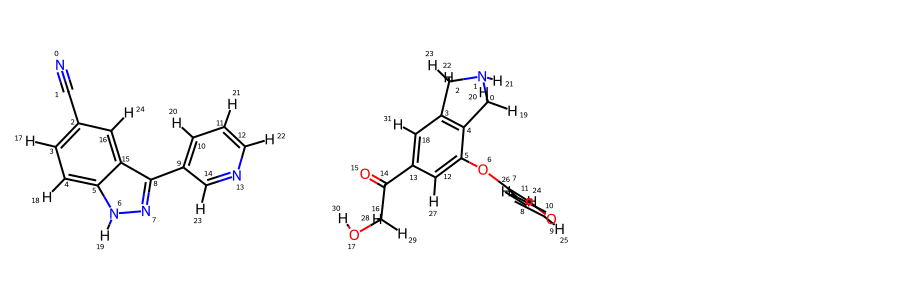

In [83]:
IPythonConsole.ShowMols([qmols[71], mols[0]], subImgSize=(300, 300))

In [16]:
view = nv.NGLWidget()
view.add_component(qmols[90])
qps[90].draw(view)
view

NGLWidget()

In [17]:
view = nv.NGLWidget()
view.add_component(mols[0])
ps[0].draw(view)
view

NGLWidget()

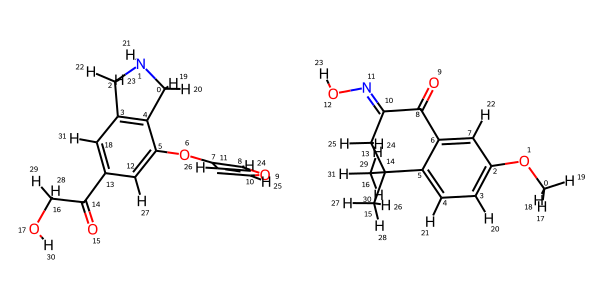

In [19]:
IPythonConsole.ShowMols([mols[0], qmols[90]], subImgSize=(300, 300), molsPerRow=2)

In [20]:
qmols[90].GetAtomWithIdx(12).GetHybridization()

rdkit.Chem.rdchem.HybridizationType.SP2

In [ ]:
matches_list[93][0]

[MDist(6|9(3.53), 0|2(2.25)),
 MDist(6|1(4.42), 0|11(5.01)),
 MDist(17|6(6.62), 2|11(5.93))]

In [22]:
qps[90].pos

array([[-4.09323859,  3.62980175,  0.32614505],
       [ 0.41406145,  3.25726751, -0.60123156],
       [ 0.41406145,  3.25726751, -0.60123156],
       [ 4.1125115 ,  0.0496501 ,  0.17838857],
       [-2.34071059,  3.05787732,  0.03606965],
       [ 1.35877203, -0.2346981 , -0.00868303],
       [ 1.35877203, -0.2346981 , -0.00868303]])

0 1 2
0 1 3
0 1 4
0 1 5
0 1 6
0 1 7
0 1 8
0 1 9
0 1 10
0 2 3
0 2 4
0 2 5
0 2 6
0 2 7
0 2 8
0 2 9
0 2 10
0 3 4
0 3 5
0 3 6
0 3 7
0 3 8
0 3 9
0 3 10
0 4 5
0 4 6
0 4 7
0 4 8
0 4 9
0 4 10
0 5 6
0 5 7
0 5 8
0 5 9
0 5 10
0 6 7
0 6 8
0 6 9
0 6 10
0 7 8
0 7 9
0 7 10
0 8 9
0 8 10
0 9 10
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 3 4
1 3 5
1 3 6
1 3 7
1 3 8
1 3 9
1 3 10
1 4 5
1 4 6
1 4 7
1 4 8
1 4 9
1 4 10
1 5 6
1 5 7
1 5 8
1 5 9
1 5 10
1 6 7
1 6 8
1 6 9
1 6 10
1 7 8
1 7 9
1 7 10
1 8 9
1 8 10
1 9 10
2 3 4
2 3 5
2 3 6
2 3 7
2 3 8
2 3 9
2 3 10
2 4 5
2 4 6
2 4 7
2 4 8
2 4 9
2 4 10
2 5 6
2 5 7
2 5 8
2 5 9
2 5 10
2 6 7
2 6 8
2 6 9
2 6 10
2 7 8
2 7 9
2 7 10
2 8 9
2 8 10
2 9 10
3 4 5
3 4 6
3 4 7
3 4 8
3 4 9
3 4 10
3 5 6
3 5 7
3 5 8
3 5 9
3 5 10
3 6 7
3 6 8
3 6 9
3 6 10
3 7 8
3 7 9
3 7 10
3 8 9
3 8 10
3 9 10
4 5 6
4 5 7
4 5 8
4 5 9
4 5 10
4 6 7
4 6 8
4 6 9
4 6 10
4 7 8
4 7 9
4 7 10
4 8 9
4 8 10
4 9 10
5 6 7
5 6 8
5 6 9
5 6 10
5 7 8
5 7 9
5 7 10
5 8 9
5 8 10
5 9 10
6 7 8
6 7 9
6 7 10
6 8 9
6 8 10

In [56]:
import numpy as np

a = np.array([1, 2])            # Length 2
b = np.array([10, 20, 30])        # Length 3
c = np.array([100, 200, 300, 400]) # Length 4

A, B, C = np.meshgrid(a, b, c, indexing='ij')

In [60]:
np.stack([A, B, C], axis=0)[np.triu_indices(3)]

IndexError: index 2 is out of bounds for axis 1 with size 2

In [59]:
np.triu_indices(3)

(array([0, 0, 0, 1, 1, 2]), array([0, 1, 2, 1, 2, 2]))

In [ ]:
A, B = np.meshgrid(a, b, indexing='ij')
np.stack([A, B, C])

array([[10, 20, 30],
       [10, 20, 30]])

In [6]:
profile.distances.pair_members

[(PharmArrowType(name='HBondAcc'), PharmArrowType(name='HBondAcc')),
 (PharmArrowType(name='HBondAcc'), PharmArrowType(name='HBondHyd')),
 (PharmArrowType(name='HBondAcc'), PharmArrowType(name='Aromatic')),
 (PharmArrowType(name='HBondHyd'), PharmArrowType(name='HBondHyd')),
 (PharmArrowType(name='HBondHyd'), PharmArrowType(name='Aromatic')),
 (PharmArrowType(name='Aromatic'), PharmArrowType(name='Aromatic'))]

In [7]:
x = profile.distances.pair_values[0]
y = profile.distances.pair_values[1]

In [16]:
import numpy as np

(x[:, None] - y)**2

array([[9.15846553e+00, 9.15037147e+00, 3.99171378e+00, 2.61963930e+00,
        1.33499774e-01, 4.64085731e-01, 1.48926315e+00, 1.74120231e+00,
        3.85352350e+00],
       [1.13276081e+01, 1.13186062e+01, 5.46289140e+00, 3.83331572e+00,
        6.77075214e-04, 1.16883877e-01, 7.76157752e-01, 9.60773829e-01,
        2.63634912e+00],
       [1.83027689e+01, 1.82913258e+01, 1.05612341e+01, 8.23924121e+00,
        7.85885186e-01, 3.25629421e-01, 9.93773197e-04, 4.57901036e-03,
        5.05750662e-01]])

In [18]:
import scipy.optimize

scipy.optimize.linear_sum_assignment((x[:, None] - y)**2)

(array([0, 1, 2]), array([4, 5, 6]))

In [13]:
dists.pair_values[0]

array([3.38144635, 3.4347291 ])

In [14]:
dists.pair_atids

[[((1,), (3, 4, 5, 6, 7)), ((9,), (3, 4, 5, 6, 7))]]

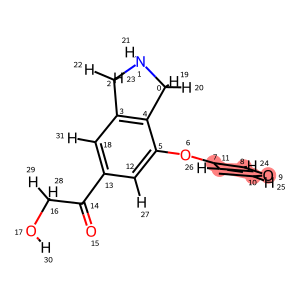

In [6]:
np.unique(dists.pair_values[0], return_index=True)

NameError: name 'np' is not defined

In [47]:
dists.pair_values[0][[ 8, 10,  4,  0]]

array([0.89806121, 1.52683479, 2.10394342, 4.46418988])

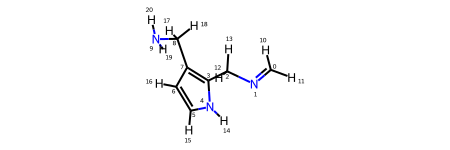

In [2]:
IPythonConsole.drawOptions.addAtomIndices = True

mol

In [ ]:
pgen.groups

[PharmGroup(name='PolarHyd', query=<rdkit.Chem.rdchem.Mol object at 0x7f1d32de3e60>),
 PharmGroup(name='EtherLikeHBA', query=<rdkit.Chem.rdchem.Mol object at 0x7f1d329de6c0>),
 PharmGroup(name='KetoLikeHBA', query=<rdkit.Chem.rdchem.Mol object at 0x7f1d329de730>),
 PharmGroup(name='FuranLikeHBA', query=<rdkit.Chem.rdchem.Mol object at 0x7f1d32557370>),
 PharmGroup(name='Aromatic6', query=<rdkit.Chem.rdchem.Mol object at 0x7f1d325570d0>)]

In [ ]:
p.feats

In [22]:
ps.feats[0].radius

array([1.7, 1.7])

In [6]:
pgen.ftypes

OrderedDict([('HBondAcc', PharmFeatureType(name='HBondAcc', type='ARROW')),
             ('HBondHyd', PharmFeatureType(name='HBondHyd', type='ARROW'))])

In [7]:
c

NameError: name 'c' is not defined

In [ ]:
{1: 2}.update({3: 4})

In [ ]:
"{sd}asd{x}"

from string import Formatter

list(Formatter.parse("", "{sd}asd{x}"))

[('', 'sd', '', None), ('asd', 'x', '', None)]